In [59]:
import sys
# Define relative path.
sys.path.append("python")

In [60]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sampling_trajectory import morris_trajectory
from screening_measures_gm_2017 import screening_measures_gm_2017

from transform_reorder import reorder_cov
from transform_distributions import covariance_to_correlation
import scipy.linalg as linalg

In [61]:
"""Perhaps I need to add the scaled Elementary Effects (by SD)"""

'Perhaps I need to add the scaled Elementary Effects (by SD)'

In [62]:
def bar_plot(input_par_array):
    new_list = input_par_array.reshape(-1, 1).tolist()
    merged = pd.Series(itertools.chain.from_iterable(new_list))
    vc = merged.value_counts().sort_index()
    vc /= float(vc.sum())
    assert vc.sum() > 0.999
    ax = vc.plot(kind='bar')
    fig = ax.get_figure()
    fig.autofmt_xdate()

In [63]:
seed = 2020
n_levels = 16
n_inputs = 3
n_traj_sample = 10_000

sample_traj_list = list()

for traj in range(0, n_traj_sample):
    seed = seed + traj
    sample_traj_list.append(morris_trajectory(n_inputs, n_levels, seed=seed))

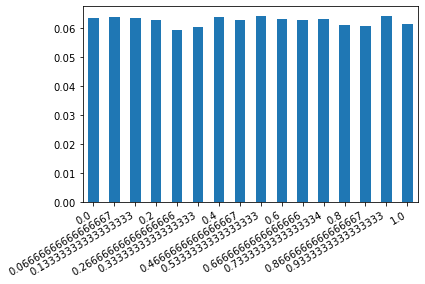

In [64]:
"Check: For some even n_levels 1.0 has double the number of observations."
bar_plot(np.vstack(sample_traj_list))

In [65]:
expectation = np.array([0, 0, 0])
"""
cov = np.array(
    [
        [1.0, 0.5, 0.0],
        [0.5, 1.0, 0.0],
        [0.0, 0.0, 1.0],
    ]
)
"""
cov = np.array(
    [
        [1.0, 0.9, 0.4],
        [0.9, 1.0, 0.0],
        [0.4, 0.0, 1.0],
    ]
)

In [66]:
def linear_function(a, b, c, *args):
    return a + b + c

In [67]:
"""I am able to replicate the results for the two normally distributed examples. The only difference is the scale because they seem to use another number of levels."""
abs_ee_ind, abs_ee_full, sd_ee_ind, sd_ee_full = screening_measures_gm_2017(linear_function, sample_traj_list, cov, n_levels, mu=expectation, numeric_zero=0.0000001)

In [68]:
"""
In my opinion, we would like to have the values for `abs_ee_ind` and `sd_ee_ind` to be equal.
However, the independet measures for dependent inputs are always smaller than the ones for the independent inputs because the positive delta gets decorrelated (decreases) for the former type.
In 2d case: delta/np.sqrt(1-rho^2). This actually re-introduces dependancies. This should not happen for an independet EE.

My proposal for improvement: Add delta after decorrrlating the sample for the independent effect.
Question: Why do the Sobol' indices follow this trend without a fixed delta? Probably they also decorrelate the squared distance between observation and mean.
"""
abs_ee_ind

array([[0.81482981],
       [0.89113359],
       [1.88468444]])

In [69]:
sd_ee_ind

array([[0.96672659],
       [1.05682964],
       [2.2352405 ]])

In [70]:
abs_ee_full

array([[10.82017083],
       [ 8.95932787],
       [ 6.64022588]])

In [71]:
sd_ee_full

array([[12.83721672],
       [10.62521197],
       [ 7.87532465]])

In [28]:
"""Ishigami"""
def ishigami(q0, q1, q2, a=2, b=3):
    """Note: Originally, this function takes uniform, not standard normally distributed inputs"""
    return np.sin(q0) + a*(np.sin(q1))**2 + b*q2**4*np.sin(q0)

In [29]:
cov = np.array(
    [
        [1.0, 0.5, 0.0],
        [0.5, 1.0, 0.0],
        [0.0, 0.0, 1.0],
    ]
)

In [30]:
a=2
b=3
vals = [0.5 + (a**2)/8 + (b*(np.pi**4))/5 + ((b**2)*(np.pi**8)/18),
        (0.5 + b*(np.pi**4)/5 + (b**2)*(np.pi**8)/50), (a**2)/8,
         0, 0, (8*b**2*np.pi**8)/225, 0, 0]
total_order = [(vals[1]+vals[5])/vals[0], vals[2]/vals[0], vals[5]/vals[0]]

In [31]:
total_order # Compare with sd_ee_ind.

[0.9998959138041636, 0.00010408619583630811, 0.6320800624240672]

In [32]:
abs_ee_ind, abs_ee_full, sd_ee_ind, sd_ee_full = screening_measures_gm_2017(ishigami, sample_traj_list, cov, n_levels, mu=expectation)

In [33]:
abs_ee_ind

array([[83.04633545],
       [ 1.64185511],
       [75.43084687]])

In [34]:
sd_ee_ind

array([[122.37646082],
       [  1.65923596],
       [ 78.14440183]])

In [35]:
abs_ee_full

array([[77.02816043],
       [55.17567412],
       [75.43084687]])

In [36]:
sd_ee_full

array([[107.58711128],
       [ 87.85210595],
       [ 78.14440183]])

In [ ]:
"""
new experiment, see on page 15 in
http://www2.stat.duke.edu/~fei/samsi/Readings/06LinkBingHengHigfYe.pdf

"""
seed = 2020
n_levels = 10
n_inputs = 8
n_traj_sample = 10_000

sample_traj_list = list()

for traj in range(0, n_traj_sample):
    seed = seed + traj
    sample_traj_list.append(morris_trajectory(n_inputs, n_levels, seed=seed))

In [ ]:
def linkletter_et_al_2006(x0, x1, x2, x3, x4, x5, x6, x7, *args):
    epsilon = np.random.normal(0, 0.05)
    return 0.2*x0 + (0.2/2)*x1 + (0.2/4)*x2 + (0.2/8)*x3 + (0.2/16)*x4 + (0.2/32)*x5 + (0.2/64)*x6 + (0.2/128)*x7 + epsilon

In [ ]:
expectation = np.array([0, 0, 0, 0, 0, 0, 0, 0])


cov = np.array(
    [
        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
    ]
)

In [ ]:
abs_ee_ind, abs_ee_full, sd_ee_ind, sd_ee_full = screening_measures_gm_2017(linkletter_et_al_2006, sample_traj_list, cov, n_levels, mu=expectation)

In [ ]:
abs_ee_ind

In [ ]:
sd_ee_ind

In [ ]:
abs_ee_full

In [ ]:
sd_ee_full